In [191]:
! ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


In [192]:
#영화리뷰 감상분석 도전하기
#데이터준비와 확인

import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [194]:
#데이터로더 구성
#실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 
#숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다


#그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 
#이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 
#data_loader 안에서는 다음을 수행해야 합니다.

#데이터의 중복 제거
#NaN 결측치 제거
#한국어 토크나이저로 토큰화
#불용어(Stopwords) 제거
#사전word_to_index 구성
#텍스트 스트링을 사전 인덱스 스트링으로 변환
#X_train, y_train, X_test, y_test, word_to_index 리턴



from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    
    
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [187]:
#word_to_index["<PAD>"] = 0
#word_to_index["<BOS>"] = 1
#word_to_index["<UNK>"] = 2  # unknown

In [195]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [201]:
print(index_to_word[5])

영화


In [204]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [205]:
# 3. 모델 구성을 위한 데이터 분석 및 가공

In [206]:
#데이터셋 내 문장 길이 분포
#적절한 최대 문장 길이 지정

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [208]:
#keras.preprocessing.sequnce.pad_sequnences을 활용한 패딩 추가

import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [209]:
# 4. 모델 구성 및 validation set 구성

#모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [210]:
# validation set으로 46182 쓰고 훈련용으로 100000 사용할 예정 

In [211]:
#RNN 모델

vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 10  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 100,689
Trainable params: 100,689
Non-trainable params: 0
_________________________________________________________________


In [212]:
#CNN 모델

vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 16)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_47 (Dense)             (None, 1)               

In [213]:
#globalmaxpooling1d() 레이어 하나만 사용

vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 10   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gmp1d = tf.keras.Sequential()
model_gmp1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp1d.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 10)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 9         
Total params: 100,097
Trainable params: 100,097
Non-trainable params: 0
_________________________________________________________________


In [214]:
# 모델 훈련전 데이터셋에서 검증셋 분리

# validation set 46182건 분리
X_val = X_train[:46182]   
y_val = y_train[:46182]

# validation set을 제외한 나머지 100000건
partial_X_train = X_train[46182:]  
partial_y_train = y_train[46182:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(100000, 41)
(100000,)


In [215]:
# 5. 모델 훈련 개시

In [216]:
#rnn모델 훈련
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
196/196 [==============================] - 3s 8ms/step - loss: 0.5331 - accuracy: 0.7508 - val_loss: 0.3870 - val_accuracy: 0.8345
Epoch 2/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3540 - accuracy: 0.8510 - val_loss: 0.3531 - val_accuracy: 0.8474
Epoch 3/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3277 - accuracy: 0.8624 - val_loss: 0.3531 - val_accuracy: 0.8476
Epoch 4/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3131 - accuracy: 0.8695 - val_loss: 0.3525 - val_accuracy: 0.8471
Epoch 5/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3059 - accuracy: 0.8740 - val_loss: 0.3605 - val_accuracy: 0.8431


In [217]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
196/196 [==============================] - 2s 7ms/step - loss: 0.5058 - accuracy: 0.7495 - val_loss: 0.3579 - val_accuracy: 0.8424
Epoch 2/5
196/196 [==============================] - 1s 5ms/step - loss: 0.3285 - accuracy: 0.8600 - val_loss: 0.3437 - val_accuracy: 0.8480
Epoch 3/5
196/196 [==============================] - 1s 6ms/step - loss: 0.2890 - accuracy: 0.8810 - val_loss: 0.3419 - val_accuracy: 0.8493
Epoch 4/5
196/196 [==============================] - 1s 5ms/step - loss: 0.2557 - accuracy: 0.8970 - val_loss: 0.3545 - val_accuracy: 0.8502
Epoch 5/5
196/196 [==============================] - 1s 5ms/step - loss: 0.2216 - accuracy: 0.9145 - val_loss: 0.3705 - val_accuracy: 0.8481


In [218]:
##globalmaxpooling1d() 레이어 하나만 사용한 모델 훈련
model_gmp1d.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 

history = model_gmp1d.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
196/196 [==============================] - 1s 4ms/step - loss: 0.6419 - accuracy: 0.6622 - val_loss: 0.5418 - val_accuracy: 0.7938
Epoch 2/5
196/196 [==============================] - 1s 4ms/step - loss: 0.4537 - accuracy: 0.8218 - val_loss: 0.4015 - val_accuracy: 0.8284
Epoch 3/5
196/196 [==============================] - 1s 4ms/step - loss: 0.3656 - accuracy: 0.8469 - val_loss: 0.3722 - val_accuracy: 0.8365
Epoch 4/5
196/196 [==============================] - 1s 4ms/step - loss: 0.3302 - accuracy: 0.8617 - val_loss: 0.3660 - val_accuracy: 0.8396
Epoch 5/5
196/196 [==============================] - 1s 4ms/step - loss: 0.3077 - accuracy: 0.8718 - val_loss: 0.3667 - val_accuracy: 0.8403


In [163]:
#학습이 끝난 모델을 테스트셋으로 평가

#rnn
print("RNN")
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)
print(results_rnn)

RNN
1517/1517 - 3s - loss: 0.3830 - accuracy: 0.8321
[0.38301920890808105, 0.8320593237876892]


In [219]:
#cnn
print("CNN")
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)
print(results_cnn)

CNN
1537/1537 - 2s - loss: 0.3799 - accuracy: 0.8454
[0.3798815906047821, 0.8453526496887207]


In [220]:
#globalmaxpooling1d() 레이어 하나만 사용한 모델
print("globalmaxpooling1d() 레이어 하나만 사용한 모델")
results_gmp1d = model_gmp1d.evaluate(X_test,  y_test, verbose=2)
print(results_gmp1d)

globalmaxpooling1d() 레이어 하나만 사용한 모델
1537/1537 - 2s - loss: 0.3781 - accuracy: 0.8349
[0.3781122863292694, 0.8349370360374451]


In [221]:
#6. Loss, Accuracy 그래프 시각화

In [222]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


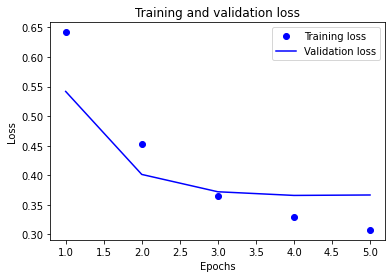

In [223]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [224]:
#loss 그래프 분석:
#epoch 3을 기준으로 tloss와 vloss의 차이가 벌어지면서 vloss가 tloss보다 많이 높아졌으니까 
#epoch는 3으로 설정하는게 더 적절해보임

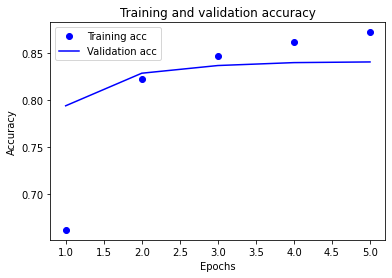

In [225]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [226]:
#accuray 그래프 분석:
#loss 그래프와 같은 이유로 epoch 5보단 2~3이 더 적절해보임

In [227]:
# 7. 학습된 Embedding 레이어 분석

In [228]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 10)


In [229]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant


# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gmp1d.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [233]:
#gensim에서 제공하는 패키지를 이용해, 
#위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사람']
vector

array([-0.05552001, -0.09984111, -0.08703337,  0.03690083,  0.00574128,
       -0.09733456, -0.08841748, -0.08387419, -0.03985668, -0.01217147],
      dtype=float32)

In [236]:
word_vectors.similar_by_word("사람")

[('!!!', 0.9871779680252075),
 ('아요', 0.9844964146614075),
 ('할머니', 0.982246994972229),
 ('호흡', 0.9783604145050049),
 ('행동', 0.9766379594802856),
 ('떠나', 0.9681214094161987),
 ('무엇', 0.9670673608779907),
 ('왕', 0.9664388298988342),
 ('!!', 0.9657636880874634),
 ('목소리', 0.9646223783493042)]

In [234]:
word_vectors.similar_by_word("시간")

[('창조', 0.9450905323028564),
 ('4', 0.9300074577331543),
 ('보단', 0.9289112687110901),
 ('성형', 0.91628098487854),
 ('먼지', 0.9060079455375671),
 ('얘', 0.9044432044029236),
 ('세이', 0.9039097428321838),
 ('.;', 0.9004266262054443),
 ('대우', 0.8975449204444885),
 ('질러', 0.8941645622253418)]

In [235]:
word_vectors.similar_by_word("이해")

[('발리', 0.9793580174446106),
 ('호불호', 0.9781672358512878),
 ('러닝', 0.9727414846420288),
 ('떳', 0.9689446091651917),
 ('결국', 0.9686387181282043),
 ('밝혀', 0.9618575572967529),
 ('네', 0.9554423689842224),
 ('기대', 0.9524935483932495),
 ('단역', 0.9462688565254211),
 ('타임', 0.9448453187942505)]

In [ ]:
# 학습된 임베딩 레이어는 별로 정확하지 않은 것 같다.

In [ ]:
# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [245]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

word2vec.similar_by_word("사람")

/tmp/ipykernel_3527/3526420923.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사람")


[('젊은이', 0.6494427919387817),
 ('여인', 0.6287257671356201),
 ('백성', 0.6063710451126099),
 ('포졸', 0.6043275594711304),
 ('죄인', 0.5960500836372375),
 ('선비', 0.5868039131164551),
 ('부녀자', 0.5654411315917969),
 ('죄수', 0.5639811754226685),
 ('구경꾼', 0.5620019435882568),
 ('손님', 0.5589558482170105)]

In [246]:
word2vec.similar_by_word("시간")

/tmp/ipykernel_3527/4202315454.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("시간")


[('분간', 0.599348783493042),
 ('간격', 0.5879659652709961),
 ('일주일', 0.5773798227310181),
 ('장시간', 0.5595555305480957),
 ('기간', 0.5561516880989075),
 ('시일', 0.5550214052200317),
 ('분만', 0.5545178055763245),
 ('며칠', 0.5476520657539368),
 ('여분', 0.5410358905792236),
 ('시간대', 0.5361416935920715)]

In [247]:
word2vec.similar_by_word("이해")

/tmp/ipykernel_3527/2816887174.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("이해")


[('파악', 0.6464853286743164),
 ('인식', 0.6374833583831787),
 ('설명', 0.6089094877243042),
 ('인지', 0.5984542369842529),
 ('해석', 0.5830858945846558),
 ('자각', 0.5620999336242676),
 ('탐구', 0.5595905780792236),
 ('통찰', 0.5560247898101807),
 ('표현', 0.5544334650039673),
 ('의사소통', 0.5483694672584534)]

In [ ]:
#사람,시간,이해에 대한 키워드에 대해 확실히 알고 있는 것 같은 결과가 나왔다.

In [250]:
#정말 똑똑한 이 임베딩 레이어로 바꿔서 다시 학습시켜보자

from tensorflow.keras.initializers import Constant

vocab_size = 10000     #어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  #워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_3527/2172419220.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_3527/2172419220.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [304]:
#모델 다시 생성

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 16)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

In [305]:
# 다시 훈련

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
196/196 [==============================] - 2s 8ms/step - loss: 0.4415 - accuracy: 0.7951 - val_loss: 0.3421 - val_accuracy: 0.8518
Epoch 2/3
196/196 [==============================] - 1s 7ms/step - loss: 0.2986 - accuracy: 0.8760 - val_loss: 0.3376 - val_accuracy: 0.8545
Epoch 3/3
196/196 [==============================] - 1s 7ms/step - loss: 0.2330 - accuracy: 0.9092 - val_loss: 0.3468 - val_accuracy: 0.8549


In [306]:
#훈련 끝난 모델을 테스트셋으로 평가

print("똑똑한 임베딩 레이어 사용한 모델")
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

똑똑한 임베딩 레이어 사용한 모델
1537/1537 - 3s - loss: 0.3594 - accuracy: 0.8503
[0.3593931496143341, 0.8503163456916809]


In [307]:
#시각화 분석

In [308]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


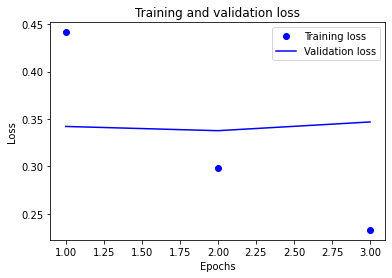

In [309]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

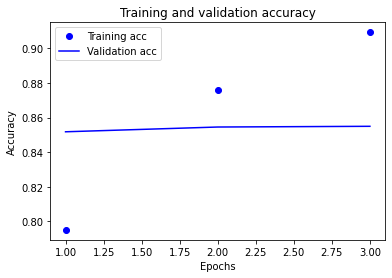

In [310]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
#마지막에 똑똑한 임베딩 레이어로 바꿨지만 정확도가 0.83~0.84 정도가 나왔는데
# epochs가 커질수록 훈련셋과 검증셋의 사이 간격이 크게 벌어지는 것이 시각화 그래프로 확인되어
# epochs 를 줄이자 정확도가 0.85 정도로 올라갔다.